# K-means classification

This notebook will classify the features of the Y89 cells (cell size and resting membrane potential) into k clusters in which each observation will be assigned to the cluster with the nearest mean (cluster centers or cluster centroid)

In [1]:
%pylab inline

from matplotlib.pyplot import style
import matplotlib.pyplot as plt

# use custom plots from minibrain
style.use('https://raw.githubusercontent.com/JoseGuzman/minibrain/master/minibrain/paper.mplstyle')

import pandas as pd

Populating the interactive namespace from numpy and matplotlib


# Load data

In [2]:
mypath = 'https://github.com/skim2021/retinoblastoma/blob/main/cell_data.csv'
mydata = pd.read_csv('./DataSets/cell_data.csv')
print(f'{mydata.shape[0]} observations')
mydata.head()

95 observations


,diameter,Vmb
0,20.89430,-27.6512
1,16.85182,-24.8687
2,17.95220,-38.0629
3,15.81813,-12.6591
4,16.68500,-36.0233


In [3]:
from scipy.stats import lognorm

In [4]:
# Define gaussian mixture
def gauss(x,mu,sigma,A):
    """
    Solves the Gaussian function of the form:
    f(x; mu, sigma, A), where
    
    x is the observation
    mu is the location of the mean
    sigma is the standard deviation
    A is the amplitude of the Gaussian function.
    """
    return A*exp(-(x-mu)**2/2/sigma**2)

def bimodal(x,mu1,sigma1,A1,mu2,sigma2,A2):
    return gauss(x,mu1,sigma1,A1)+gauss(x,mu2,sigma2,A2)

In [5]:
from scipy.optimize import curve_fit

## Bimodal distribution of cell diameters

,params,sigma
mu1,15.167134,0.231268
sigma1,2.121785,0.440581
A1,22.224292,2.658431
mu2,28.538598,2.526905
sigma2,8.925005,2.491280
A2,6.733215,1.051526


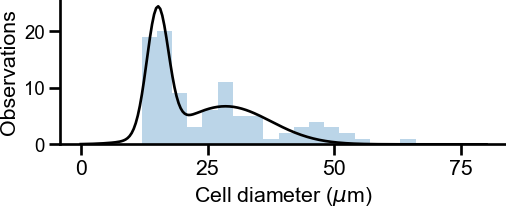

In [6]:
diameters = mydata.diameter.values

plt.figure(figsize=(6,2))
mybins = np.arange(0,80,3)
y, x, _ = plt.hist(diameters, mybins, color='C0', alpha =0.3)

x=(x[1:]+x[:-1])/2 # for len(x)==len(y)

expected = (15, 10, 20, 50, 20, 10)

params,cov = curve_fit(bimodal,x,y,expected)
xfit = np.linspace(0,80,200)
plt.plot(xfit,bimodal(xfit,*params), color='k', lw=2)
plt.ylabel('Observations');
plt.xlabel('Cell diameter ($\mu$m)');
plt.xticks(np.arange(0,100,25));

sigma = np.sqrt(np.diag(cov))
fit_diam = pd.DataFrame(data={'params':params,'sigma':sigma},index=bimodal.__code__.co_varnames[1:])
fit_diam

## Bimodal distribution of cell resting membrane potential

,params,sigma
mu1,-63.835137,1.708328
sigma1,2.310628,1.643544
A1,10.309785,6.922437
mu2,-28.623628,0.931478
sigma2,12.084117,0.954624
A2,13.853369,0.925939


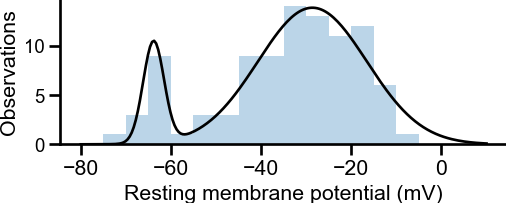

In [7]:
vrest = mydata.Vmb.values

plt.figure(figsize=(6,2))
mybins = np.arange(-80,10,5)
y, x, _ = plt.hist(vrest, mybins, color='C0', alpha =0.3)

x=(x[1:]+x[:-1])/2 # for len(x)==len(y)

expected = (-70, 5, 2, -20, 10, 10)

params,cov = curve_fit(bimodal,x,y,expected)
xfit = np.linspace(-80, 10,200)
plt.plot(xfit,bimodal(xfit,*params), color='k', lw=2);
plt.ylabel('Observations');
plt.xlabel('Resting membrane potential (mV)');

sigma = np.sqrt(np.diag(cov))
fit_vrest = pd.DataFrame(data={'params':params,'sigma':sigma},index=bimodal.__code__.co_varnames[1:])
fit_vrest

## Plot all together

In [8]:
fit_diam.params.mu1, fit_vrest.params.mu1

(15.167134308961382, -63.835136582515055)

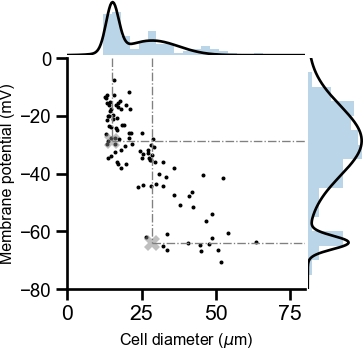

In [9]:
grid = plt.GridSpec(5,5, wspace= 0.05, hspace = 0.05)
fig = plt.figure(figsize=(4,4))

# scatter plot
dots = fig.add_subplot(grid[1:5, 0:4])
mymaks = np.isnan(mydata.Vmb.values)
y = np.ma.array(mydata.Vmb.values, mask = mymaks).compressed()
x = np.ma.array(mydata.diameter.values, mask = mymaks).compressed()
# centroid for 
dots.scatter(x,y,s=4, color='k')
mymarker = dict(markersize = 12, color='gray', alpha = 0.5)
dots.plot(fit_diam.params.mu1,fit_vrest.params.mu2, marker='X', **mymarker)
dots.plot(fit_diam.params.mu2,fit_vrest.params.mu1, marker='X', **mymarker)

dots.set_yticks(np.arange(-80,10,20));
dots.set_xticks(np.arange(0,100,25));
dots.set_xlim(0,80)
dots.set_xlabel('Cell diameter ($\mu$m)', fontsize=12);
dots.set_ylim(-80, 0)
dots.set_ylabel('Membrane potential (mV)', fontsize=12)
myparams = dict(color='gray', linestyle='-.', lw=1)
dots.hlines(fit_vrest.params.mu1, xmin = fit_diam.params.mu2, xmax = 80, **myparams)
dots.hlines(fit_vrest.params.mu2, xmin = fit_diam.params.mu1, xmax = 80, **myparams)
dots.vlines(fit_diam.params.mu1, ymin = 0, ymax = fit_vrest.params.mu2, **myparams)
dots.vlines(fit_diam.params.mu2, ymin = 0, ymax = fit_vrest.params.mu1,**myparams)

# up histogram
up = fig.add_subplot(grid[0, 0:4])
mybins = np.arange(0,80,3)
y, x, _ = up.hist(diameters, mybins, color='C0', alpha =0.3)
x=(x[1:]+x[:-1])/2 # for len(x)==len(y)
expected = (15, 10, 20, 70, 20, 10)

params,cov = curve_fit(bimodal,x,y,expected)
xfit = np.linspace(0,80,200)
up.plot(xfit,bimodal(xfit,*params), color='k', lw=2)
up.set_xticks(np.arange(0,100,25));
up.set_xlim(0,80)
up.axis('off')

# left histogram
left = fig.add_subplot(grid[1:5,4:5])
mybins = np.arange(-80,10,5)
y, x, _ = left.hist(vrest, mybins, color='C0', alpha =0.3, orientation='horizontal')
x=(x[1:]+x[:-1])/2 # for len(x)==len(y)
expected = (-70, 5, 2, -20, 10, 10)

params,cov = curve_fit(bimodal,x,y,expected)
xfit = np.linspace(-80, 0,200)
left.plot(bimodal(xfit,*params), xfit, color='k', lw=2);
#left.set_xticks(np.arange(0,100,25));
left.set_ylim(-80,0);
left.axis('off');



# Cluster with two centroids 

In [10]:
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans

In [11]:
myscaler = StandardScaler()
z_score = myscaler.fit_transform(mydata)

In [12]:
myscaler.mean_, myscaler.scale_

(array([ 25.67656951, -34.29449021]), array([12.06188709, 15.82171801]))

In [13]:
cfs = KMeans(n_clusters=2).fit(z_score)

In [14]:
# Add groups and colors
mydata['kgroup'] = cfs.labels_


idx_up   = np.where(cfs.labels_ == cfs.labels_[np.argmax(mydata.Vmb)])
idx_down = np.where(cfs.labels_ == cfs.labels_[np.argmin(mydata.Vmb)])[0]

myblue = '#55a0fb'
myred = '#f94040'

# assign color according to index (up is blue, down in red)
mydata['kcolor'] = myblue
mydata.at[idx_down,'kcolor'] = myred

In [15]:
from scipy.spatial.distance import cdist

def plot_radii(mykmeans, X, ax = None):
    """
    Plots k-centroids from a kmeans model
    
    Arguments
    ---------
    mykmeans (Kmeans object)
        (sklearn.sklearn.cluster.Kmeans model)
    
    X (2D-Numpy array)
        The observations ith the observations)
    
    ax (an axis object)
    """
    # plot the input data
    ax = ax or plt.gca()
    
    labels = mykmeans.labels_ # read labels

    centers = myscaler.inverse_transform(mykmeans.cluster_centers_) # centroids corrected for normalization!
    
    radii = [cdist(X[labels == i], [center]).max() for i, center in enumerate(centers)]
    
    for c, r in zip(centers, radii):
        center = c
        print(f'center location : {c}')
        ax.plot(c[0],c[1], marker='X', color='gray', markersize = 16, alpha = 0.5)
        mycircle = plt.Circle(center, r, color='gray', lw=2, alpha=0.5, zorder=1, fill=False)
        ax.add_patch(mycircle)

center location : [ 41.27397911 -54.46126071]
center location : [ 19.15824909 -25.86658612]


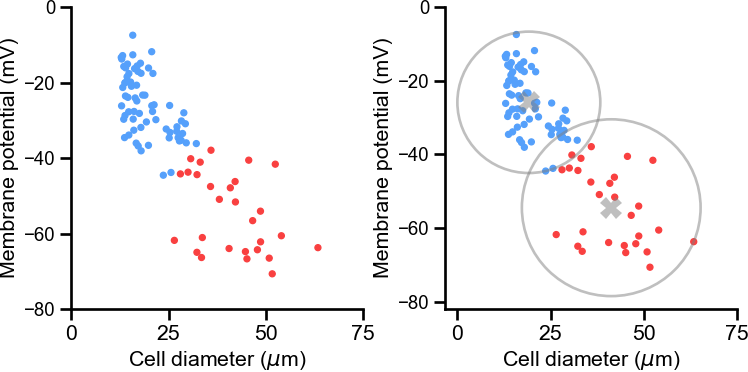

In [16]:
fig, ax = plt.subplots(1,2, figsize = (8,4))
fig.tight_layout()

ax[0].scatter(mydata.diameter, mydata.Vmb, c = mydata.kcolor, s = 20)

plot_radii(mykmeans = cfs, X = mydata.values[:,0:2], ax=ax[1])
ax[1].scatter(mydata.diameter, mydata.Vmb, c = mydata.kcolor, s = 20)

for myax in ax:
    myax.set_xlabel("Cell diameter ($\mu$m)");
    myax.set_ylabel('Membrane potential (mV)');
    myax.set_yticks(np.arange(-80,10,20));
    myax.set_xticks(np.arange(0,100,25));

In [17]:
mydata.head()

,diameter,Vmb,kgroup,kcolor
0,20.89430,-27.6512,1,#55a0fb
1,16.85182,-24.8687,1,#55a0fb
2,17.95220,-38.0629,1,#55a0fb
3,15.81813,-12.6591,1,#55a0fb
4,16.68500,-36.0233,1,#55a0fb


In [18]:
mydata.to_csv('./DataSets/Kmeans_classification.csv')

# Calculate inertias

In [19]:
inertia = list()
for k in range(2,20):
    clf = KMeans(n_clusters = k, init = 'k-means++').fit(z_score)
    inertia.append( clf.inertia_)

    

Number of optimal k-clusters: 2


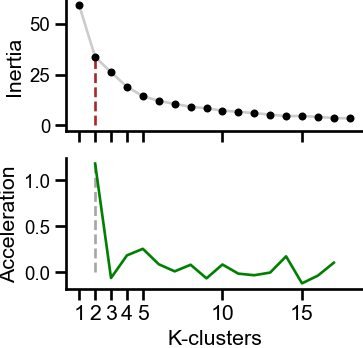

In [20]:
idx = np.arange(1, len(inertia) + 1)

fig, ax = plt.subplots(2, 1, figsize=(4,4), sharex=True)

ax[0].plot(idx, inertia, '-', color='gray', alpha = 0.4)
ax[0].plot(idx, inertia, 'ko', ms=6)
ax[0].set_xticks([1,2,3,4,5, 10, 15])

ax[0].set_ylabel('Inertia');

acceleration = np.diff(np.sqrt(inertia), 2)  # 2nd derivative of the distances

ax[1].plot(idx[:-2] + 1, acceleration, 'g-', ms=8)
ax[1].set_ylabel('Acceleration')
ax[1].set_xlabel('K-clusters')


# calculate clusters
k = acceleration.argmax() + 2  # if idx 0 is the max of this we want 2 clusters
ax[0].vlines(x = k, ymin = 0, ymax = inertia[k-1], color='brown', linestyle='--')
ax[1].vlines(x = k, ymin = 0, ymax = acceleration[k-2], color='gray', linestyle='--', alpha=0.7)

print(f'Number of optimal k-clusters: {k}')